## Incentivizing fairness in Peer Review - Simulation

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [4]:
BASE_REPUTATION = 100
SIGMA = 10
NUM_AGENTS = 100

In [5]:
class ItemClass:

    id_iter = itertools.count()
    items = {}

    def __init__(self):
        self.id = next(self.id_iter)
        self.items[self.id] = self

    @classmethod
    def get(cls, id):
        return cls.items[id]

In [7]:
class Agent(ItemClass):
    
    def __init__(self, colludingGroupId=None):
        super().__init__()

        if colludingGroupId is not None:
            ColludingGroup.get(colludingGroupId).add(self.id)
            self.colludingGroupId = colludingGroupId
        else:
            self.colludingGroupId = None

        self.reputation = BASE_REPUTATION
        self.papers = set()
        self.scores = {}

    @property
    def group(self):
        if self.colludingGroupId is None:
            return None
        else:
            return ColludingGroup.get(self.colludingGroupId)

    def inSameGroupAs(self, other):
        return self.colludingGroupId is not None and self.colludingGroupId == other.colludingGroupId

    def grade(self, paperId):
        if paperId in self.papers:
            return
        paper = Paper.get(paperId)
        if paper.owner.inSameGroupAs(self):
            score = np.random.normal(paper.trueScore + self.group.delta, self.group.sigma)
        else:
            score = np.random.normal(paper.trueScore, SIGMA)
        paper.scores[self.id] = score
        self.scores[paper.id] = score

    def resetReputation(self):
        self.reputation = BASE_REPUTATION

    def penalizeGrading(self, paperId, penaltyFunc):
        if paperId in self.papers:
            return
        penalty = penaltyFunc(self.scores[paperId] - Paper.get(paperId).trueScore)
        self.reputation -= penalty

In [8]:
class ColludingGroup(ItemClass):

    def __init__(self, delta, sigma):
        """
        Args:
            delta: Each agent in the colluding group grades
                   each other's paper from a distribution 
                   with mean trueScore + delta 
            sigma: The std deviation of the normal distribution
                   around the updated mean from which colluding
                   scores are drawn
        """
        super().__init__()
        self.agents = set()
        self.delta = delta
        self.sigma = sigma
    
    def add(self, agentId):
        self.agents.add(agentId)

In [9]:
class Paper(ItemClass):

    def __init__(self, ownerId, trueScore):
        super().__init__()
        self.ownerId = ownerId
        Agent.get(ownerId).papers.add(self.id)
        self.trueScore = trueScore
        self.scores = {}

    @property
    def owner(self):
        if self.ownerId is None:
            return None
        else:
            return Agent.get(self.ownerId)
    
    @property
    def avgScore(self):
        scoreValues = self.scores.values()
        if len(scoreValues) > 0:
            return sum(scoreValues) / len(scoreValues)
        else:
            return 0

In [15]:
def simulation(num_agents=NUM_AGENTS, collusion_group_size=10, group_delta=20, group_sigma=5, num_iterations=5, penaltyFunc=(lambda x: 0.01 * x if x > 0 else 0)):
    agents = []
    ring = ColludingGroup(group_delta, group_sigma)
    for i in range(collusion_group_size):
        a = Agent(ring.id)
        agents.append(a)
    for i in range(num_agents - collusion_group_size):
        a = Agent()
        agents.append(a)

    for _ in range(num_iterations):

        # Generate papers
        papers = []
        for agent in agents:
            paper = Paper(agent.id, 100 * np.random.random())
            papers.append(paper)

        # Scoring of papers
        for paper in papers:
            for agent in agents:
                agent.grade(paper.id)

        # Penalties
        for paper in papers:
            for agent in agents:
                agent.penalizeGrading(paper.id, penaltyFunc)

    return agents, ring

In [22]:
def getAverageReputationDifference(collusion_group_size, num_iterations):
    agents, ring = simulation(collusion_group_size=collusion_group_size, num_iterations=num_iterations)
    reputations = [agent.reputation for agent in agents]
    ringReputations = [Agent.get(agentId).reputation for agentId in ring.agents]
    avgRep = sum(reputations) / len(reputations)
    avgRingRep = sum(ringReputations) / len(ringReputations)
    return avgRep - avgRingRep

In [23]:
ringSizes = [5*i for i in range(1, 21)]
repDiffs = [getAverageReputationDifference(ringSize, 5) for ringSize in ringSizes]

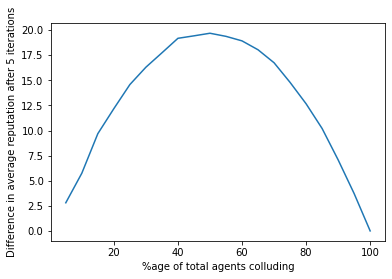

In [30]:
plt.plot(ringSizes, repDiffs)
plt.xlabel("%age of total agents colluding")
plt.ylabel("Difference in average reputation after 5 iterations")
plt.savefig("AvgDiffFraction")

In [31]:
durations = [i for i in range(1,11)]
repDiffs2 = [getAverageReputationDifference(10, duration) for duration in durations]

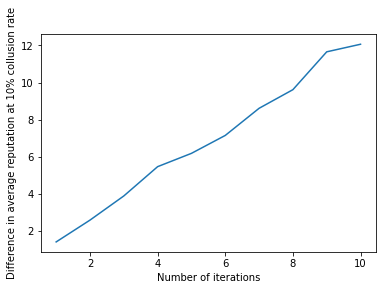

In [33]:
plt.plot(durations, repDiffs2)
plt.xlabel("Number of iterations")
plt.ylabel("Difference in average reputation at 10% collusion rate")
plt.savefig("AvgDiffTime")